In [9]:
!pip install nltk


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 14.1 MB/s  0:00:00

   ---------------------------------------- 0/2 [click]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   -------------------- ------------------- 1/2 [nltk]
   ----

In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shiva\AppData\Roaming\nltk_data...


True

In [2]:
!pip install wordcloud


Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install umap-learn


Defaulting to user installation because normal site-packages is not writeable

   -------------------- ------------------- 1/2 [umap-learn]
   ---------------------------------------- 2/2 [umap-learn]



In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text Processing
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

# Clustering & Visualization
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import umap

# Utilities
import joblib
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Load dataset
df = pd.read_csv('dataset.csv')

# Quick look at the data
df.head()
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


,release_year
count,7787.000000
mean,2013.932580
std,8.757395
min,1925.000000
25%,2013.000000
50%,2017.000000
75%,2018.000000
max,2021.000000


# Problem Statement & Target Analysis

In [4]:
print(df.columns)


Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')


In [6]:
# Create a label column (for example: Movie = 1, TV Show = 0)
df['label'] = df['type'].apply(lambda x: 1 if x == 'Movie' else 0)

# Check target
print(df['label'].value_counts())

# Check missing values
print(df.isnull().sum())

# Check unique IDs
print(df['show_id'].nunique())


label
1    5377
0    2410
Name: count, dtype: int64
show_id            0
type               0
title              0
director        2389
cast             718
country          507
date_added        10
release_year       0
rating             7
duration           0
listed_in          0
description        0
label              0
dtype: int64
7787


# Exploratory Data Analysis (EDA)

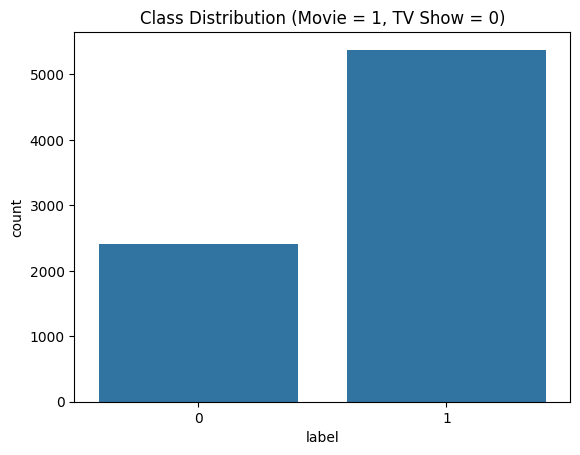

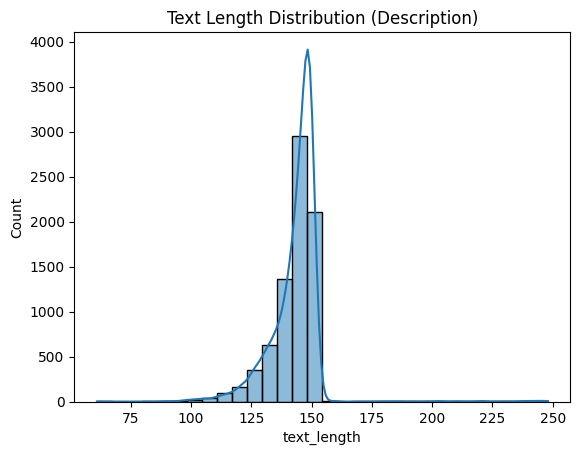

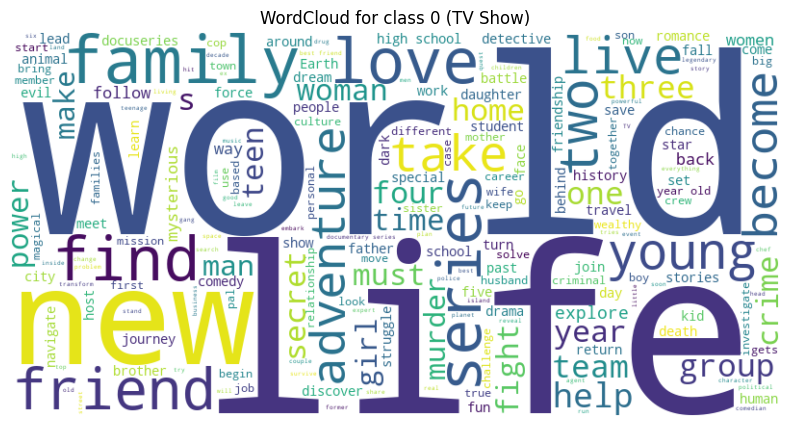

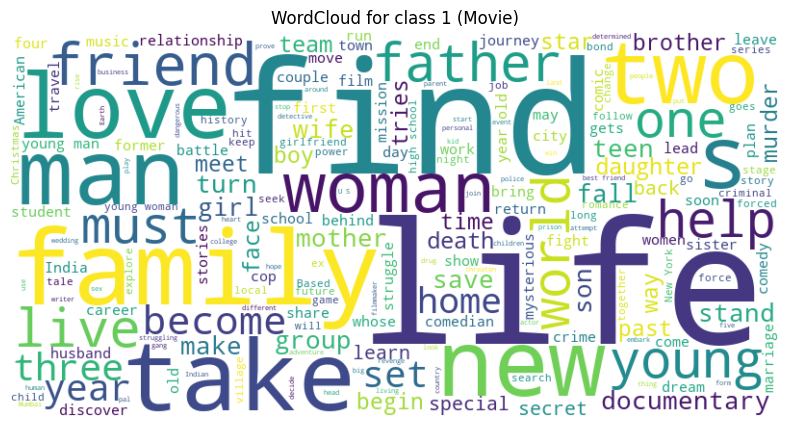

In [8]:
# Class Distribution
sns.countplot(x='label', data=df)
plt.title('Class Distribution (Movie = 1, TV Show = 0)')
plt.show()

# Text Length Distribution
df['text_length'] = df['description'].apply(lambda x: len(str(x)))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title('Text Length Distribution (Description)')
plt.show()

#  WordCloud per class
for label in df['label'].unique():
    # Combine all descriptions for this label
    text = ' '.join(df[df['label'] == label]['description'].dropna())
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white'
    ).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for class {label} ({"Movie" if label==1 else "TV Show"})')
    plt.show()


 # Data Cleaning

In [9]:
import re
import string
from nltk.stem import WordNetLemmatizer

# Function to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+|www.\S+', '', text)  # Remove URLs
    text = re.sub(r'\S+@\S+', '', text)  # Remove emails
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning
df['clean_text'] = df['description'].apply(clean_text)

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()])
)


# Feature Engineering

In [11]:
import numpy as np
import string
from nltk.corpus import stopwords

# Average word length
df['avg_word_length'] = df['clean_text'].apply(
    lambda x: np.mean([len(w) for w in x.split()]) if len(x.split()) > 0 else 0
)

# Number of stopwords
df['num_stopwords'] = df['clean_text'].apply(
    lambda x: sum([1 for w in x.split() if w in stopwords.words('english')])
)

# Punctuation count
df['punctuation_count'] = df['description'].apply(
    lambda x: sum([1 for c in str(x) if c in string.punctuation])
)


# Train-Test Split

In [12]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# TF-IDF Vectorization

In [13]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.85, min_df=5)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


# Model Training

In [14]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

# LinearSVC
svc = LinearSVC(class_weight='balanced')
svc.fit(X_train_tfidf, y_train)
y_pred_svc = svc.predict(X_test_tfidf)


# Evaluation

In [15]:
print("Logistic Regression Metrics")
print(classification_report(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

print("LinearSVC Metrics")
print(classification_report(y_test, y_pred_svc))
print(confusion_matrix(y_test, y_pred_svc))


Logistic Regression Metrics
              precision    recall  f1-score   support

           0       0.54      0.63      0.58       482
           1       0.82      0.76      0.79      1076

    accuracy                           0.72      1558
   macro avg       0.68      0.70      0.69      1558
weighted avg       0.74      0.72      0.73      1558

[[305 177]
 [256 820]]
LinearSVC Metrics
              precision    recall  f1-score   support

           0       0.52      0.59      0.55       482
           1       0.81      0.75      0.78      1076

    accuracy                           0.70      1558
   macro avg       0.66      0.67      0.67      1558
weighted avg       0.72      0.70      0.71      1558

[[286 196]
 [264 812]]


# Hyperparameter Tuning

In [16]:
params = {'C':[0.1,1,10], 'penalty':['l2']}
grid = GridSearchCV(LogisticRegression(max_iter=1000, class_weight='balanced'), params, cv=5, scoring='f1_macro')
grid.fit(X_train_tfidf, y_train)
best_model = grid.best_estimator_


# Clustering Exceptional Cases

In [17]:
kmeans = KMeans(n_clusters=3, random_state=42)
X_tfidf_all = tfidf.fit_transform(df['clean_text'])
kmeans.fit(X_tfidf_all)

df['cluster'] = kmeans.labels_


# Save Model & Vectorizer

In [19]:
import os
import joblib

# Create folder if it doesn't exist
os.makedirs('outputs', exist_ok=True)

# Save model and vectorizer
joblib.dump(best_model, 'outputs/model_best.joblib')
joblib.dump(tfidf, 'outputs/tfidf_vectorizer.joblib')


['outputs/tfidf_vectorizer.joblib']